In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [4]:
train_dataset = datasets.CIFAR10(root="./data",train=True,download=True,transform=train_transforms)
test_dataset = datasets.CIFAR10(root="./data",train=False,download=True,transform=test_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)

Files already downloaded and verified
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

In [6]:
for param in model.parameters():
    param.requires_grad = False


In [7]:
model.classifier[1] = nn.Linear(model.classifier[1].in_features,num_classes)
model = model.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
def train_model(model, loader, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        correct = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            correct += (outputs.argmax(1) == labels).sum().item()
        acc = correct / len(loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] Accuracy: {acc:.4f}")

In [10]:
train_model(model, train_loader, optimizer, epochs=5)

Epoch [1/5] Accuracy: 0.6511
Epoch [2/5] Accuracy: 0.7069
Epoch [3/5] Accuracy: 0.7107
Epoch [4/5] Accuracy: 0.7181
Epoch [5/5] Accuracy: 0.7185


In [11]:
for name, param in model.named_parameters():
    if "features.18" in name:  
        param.requires_grad = True

In [12]:
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),lr=1e-4)

In [13]:
train_model(model, train_loader, optimizer, epochs=10)


Epoch [1/10] Accuracy: 0.7331
Epoch [2/10] Accuracy: 0.7541
Epoch [3/10] Accuracy: 0.7648
Epoch [4/10] Accuracy: 0.7776
Epoch [5/10] Accuracy: 0.7817
Epoch [6/10] Accuracy: 0.7907
Epoch [7/10] Accuracy: 0.7952
Epoch [8/10] Accuracy: 0.7995
Epoch [9/10] Accuracy: 0.8017
Epoch [10/10] Accuracy: 0.8097


In [16]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.82      0.88      0.85      1000
  automobile       0.90      0.91      0.90      1000
        bird       0.81      0.76      0.78      1000
         cat       0.67      0.72      0.70      1000
        deer       0.81      0.78      0.80      1000
         dog       0.79      0.71      0.75      1000
        frog       0.83      0.88      0.85      1000
       horse       0.86      0.85      0.85      1000
        ship       0.89      0.87      0.88      1000
       truck       0.89      0.90      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



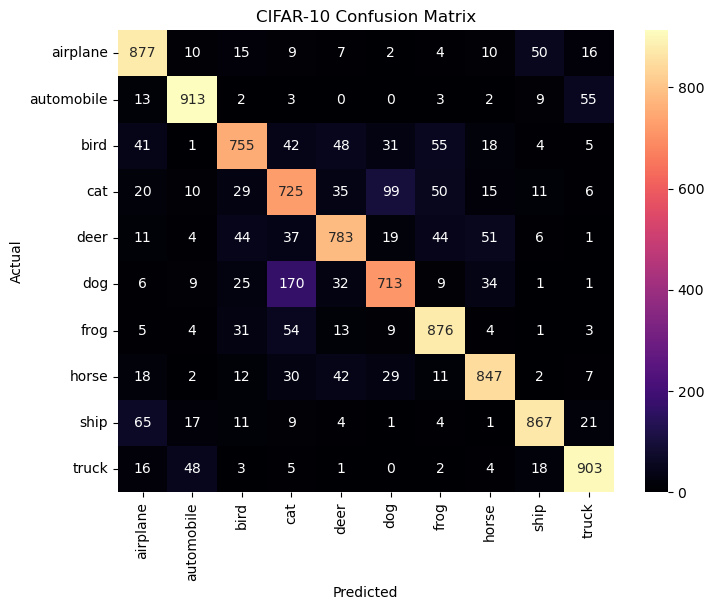

In [17]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm,annot=True,fmt="d",cmap="magma",xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CIFAR-10 Confusion Matrix")
plt.show()